In [1]:
# Copyright (c) Meta Platforms, Inc. and affiliates.

# Video segmentation with SAM 2

This notebook shows how to use SAM 2 for interactive segmentation in videos. It will cover the following:

- adding clicks on a frame to get and refine _masklets_ (spatio-temporal masks) 
- propagating clicks to get _masklets_ throughout the video
- segmenting and tracking multiple objects at the same time

We use the terms _segment_ or _mask_ to refer to the model prediction for an object on a single frame, and _masklet_ to refer to the spatio-temporal masks across the entire video. 

If running locally using jupyter, first install `segment-anything-2` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything-2#installation) in the repository.

In [2]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pandas as pd
import torch
import json

In [3]:
# use bfloat16 for the entire notebook
torch.autocast(device_type="cuda", dtype=torch.bfloat16).__enter__()

if torch.cuda.get_device_properties(0).major >= 8:
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True

### Loading the SAM 2 video predictor

In [4]:
from sam2.build_sam import build_sam2_video_predictor
sam2_checkpoint = "../checkpoints/sam2_hiera_large.pt"
model_cfg = "sam2_hiera_l.yaml"
predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint)

/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/modeling/sam/transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [5]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def sort_and_filter_images(directory, keyword):
    """
    Scans a directory for JPEG images, filters those that include a specific keyword in the filename,
    and sorts them based on the integer value that appears after 'f_' in the filename.

    Parameters:
    - directory (str): The path to the directory containing the images.
    - keyword (str): The keyword to filter filenames by (e.g., '_c1').

    Returns:
    - List[str]: A list of filtered and sorted filenames.
    """
    # Scan all the JPEG frame names in the directory
    frame_names = [
        p for p in os.listdir(directory)
        if os.path.splitext(p)[-1].lower() in [".jpg", ".jpeg"]
    ]

    # Filter to include only images that contain the keyword
    filtered_frames = [name for name in frame_names if keyword in name]

    # Sort by the integer number after 'f_'
    filtered_frames.sort(key=lambda name: int(name.split('_f_')[1].split('_')[0]))

    return filtered_frames
def sample_points(mask, num_samples):
    if num_samples == 0:
        return np.array([[]])
    """Sample points where the mask is True."""
    # Find indices where the mask is True
    y_indices, x_indices = np.where(mask)
    total_points = len(x_indices)
    if num_samples > total_points:
        raise ValueError(f"num_samples ({num_samples}) should be less than or equal to the total number of points ({total_points}).")
    # Randomly select `num_samples` points
    chosen_indices = np.random.choice(len(x_indices), num_samples, replace=False)
    # Extract the corresponding points
    sampled_points = np.array(list(zip(x_indices[chosen_indices], y_indices[chosen_indices])), dtype=np.float32)
    return sampled_points


In [6]:
def open_frame_firstlight(meta_data, index):
    header_size=0
    # Calculate the size of each image in bytes
    img_size = meta_data['height'] * meta_data['width']
    # Calculate the offset to the desired image
    
    with open(meta_data['filename_abs'], 'rb') as f:
        f.seek(0, 2)  # Move the cursor to the end of the file
        total_size = f.tell()  # `tell` gives you the current position, which is the size
        #print("Total file size using file object:", total_size, "bytes")
    offset = header_size + np.int64(img_size) * 2 * np.int64(index)  # 2 bytes per pixel for 16-bit images
    with open(meta_data['filename_abs'], 'rb') as f:
        # Seek to the desired position
        f.seek(offset)
        # Read the image data and reshape it
        img_data = np.fromfile(f, dtype=np.int16, count=img_size)  # read as 16-bit signed integers
        img = img_data.reshape(meta_data['height'], meta_data['width'])
        #print(f'relative_frame  = {index}, first four {img[0,:4]}')
        # Extract the first two pixels from the first row
        first_pixel = img[0, 0]
        second_pixel = img[0, 1]

        # Combine the first and second pixels to form a 32-bit integer frame counter
        # Convert the pixels to 32-bit integers to avoid issues with negative values and bit manipulation
        frame_counter = (second_pixel.astype(np.int32) << 16) | (first_pixel & 0xFFFF)

        #print("Frame counter:", frame_counter)
        img[0, :4] = 0    #Removing the tag 
        white_pixel = 7000
        black_pixel = 0
        img[img > white_pixel] = white_pixel
        img[img < black_pixel] = black_pixel
        img_normalized = 255 * (img.astype(np.int32)) / (white_pixel) #TODO check if this is the correct normalization to keep the details and avoid artifical oversaturation
        image_plus_camera_frame_counter = {'camera_frame_counter': frame_counter, 'img': img_normalized}
    return image_plus_camera_frame_counter

#### Select an example video

We assume that the video is stored as a list of JPEG frames with filenames like `<frame_index>.jpg`.

For your custom videos, you can extract their JPEG frames using ffmpeg (https://ffmpeg.org/) as follows:
```
ffmpeg -i <your_video>.mp4 -q:v 2 -start_number 0 <output_dir>/'%05d.jpg'
```
where `-q:v` generates high-quality JPEG frames and `-start_number 0` asks ffmpeg to start the JPEG file from `00000.jpg`.

#### Initialize the inference state

In [7]:
import os
import shutil  # Import shutil for file operations
# Original directory where the video frames are stored

masks_directory = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/CREDgt_set_4/Masks"
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/20240708_09_00_12072024_113101.raw"

_unique_id='gt4_v1_23p_32'
################

masks_directory = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/CREDgt_set_4_v3/CREDgt_set_4/Masks/"
raw_video_dir = "/mnt/md126/users/mohamed/projects/AM/Data/RAW/ByDay/20240712/CRED/20240708_09_00/20240708_09_00_12072024_113101.raw"

_unique_id='gt4_v3_ew8r3'
################

num_frames = 50
skiprate = 50
slected_mask_index = 5 # the index is the order of the mask in the list of masks xinyue has labeled. 
data_set_tag = f'CREDgt_set_4_20240708_09_00_12072024_113101_v1_selected_mask{slected_mask_index}_unique_id{_unique_id}'
flood_masks = sort_and_filter_images(masks_directory, "_c1")   # Sort and filter the images
voids_masks = sort_and_filter_images(masks_directory, "_c2")   # Sort and filter the images
masks_frames = [int(name.split('_f_')[1].split('_')[0]) for name in flood_masks]

In [8]:
mask_frame = masks_frames[slected_mask_index] # index based camera frame number
flood_mask_path = flood_masks[slected_mask_index]
voids_mask_path = voids_masks[slected_mask_index]



In [9]:
# Temporary directory to save reordered frames
temp_dir = f"./videos/{data_set_tag}/"
orginal_dir = f"{temp_dir}/orginal/"
sam_temp_dir = f"{temp_dir}/sam/orginal/"
sam_results_dir = f"{temp_dir}/sam/results/"
xinyue_dir = f"{temp_dir}/xinyue/"

In [10]:
parameters = {
    "mask_frame_used": slected_mask_index,
    "model_name": "SAM 2",
    "raw_file_directory": raw_video_dir,
    "masks_directory": masks_directory,
    "num_frames": num_frames,
    "skiprate": skiprate,
    "unique_id": _unique_id,
    "temp_dir": temp_dir,
    "orginal_dir": orginal_dir,
    "sam_temp_dir": sam_temp_dir,
    "sam_results_dir": sam_results_dir,
    "xinyue_dir": xinyue_dir,
    'sam2_checkpoint': sam2_checkpoint,
    'model_cfg': model_cfg
}

In [11]:


shutil.rmtree(temp_dir, ignore_errors=True)  # Remove the directory if it already exists
os.makedirs(temp_dir, exist_ok=True) 
os.makedirs(xinyue_dir, exist_ok=True) 
os.makedirs(orginal_dir, exist_ok=True) 
os.makedirs(sam_temp_dir, exist_ok=True)
os.makedirs(f"{sam_results_dir}/masks/", exist_ok=True) 
os.makedirs(f"{sam_results_dir}/overlay/", exist_ok=True) 

frames_indices = [ mask_frame ]

for i in range(num_frames):
    frames_indices.append(mask_frame + i*skiprate) # index based camera frame number
frames_indices = list(set(frames_indices)) 
frames_indices.sort()
mask_index = frames_indices.index(mask_frame) # sam index
image_meta_data = {'filename_abs': raw_video_dir, 'height': 512, 'width': 640}
mask_frame = open_frame_firstlight(image_meta_data, mask_frame)['img']
pixel_wise_diff_list = []
for i in frames_indices: # index based camera frame number
    frame = open_frame_firstlight(image_meta_data, i)
    img_array = frame['img']
    pixel_wise_diff = np.linalg.norm(img_array - mask_frame)
    pixel_wise_diff_list.append(pixel_wise_diff)
    img = Image.fromarray(img_array)
    img = img.convert('L')
    img.save(f"{orginal_dir}/{i}.jpg") 
    img.save(f"{sam_temp_dir}/{frames_indices.index(i)}.jpg") # sam index 1,2,3,4,5,6,7,8,9,10,..........
parameters['frames_indices'] = frames_indices

SAM 2 requires stateful inference for interactive video segmentation, so we need to initialize an **inference state** on this video.

During initialization, it loads all the JPEG frames in `video_path` and stores their pixels in `inference_state` (as shown in the progress bar below).

In [12]:
inference_state = predictor.init_state(video_path=sam_temp_dir)

frame loading (JPEG): 100%|██████████| 50/50 [00:01<00:00, 39.17it/s]


### Example 1: Segment & track one object

Note: if you have run any previous tracking using this `inference_state`, please reset it first via `reset_state`.

(The cell below is just for illustration; it's not needed to call `reset_state` here as this `inference_state` is just freshly initialized above.)

In [13]:
predictor.reset_state(inference_state)

#### Step 1: Promting


/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(


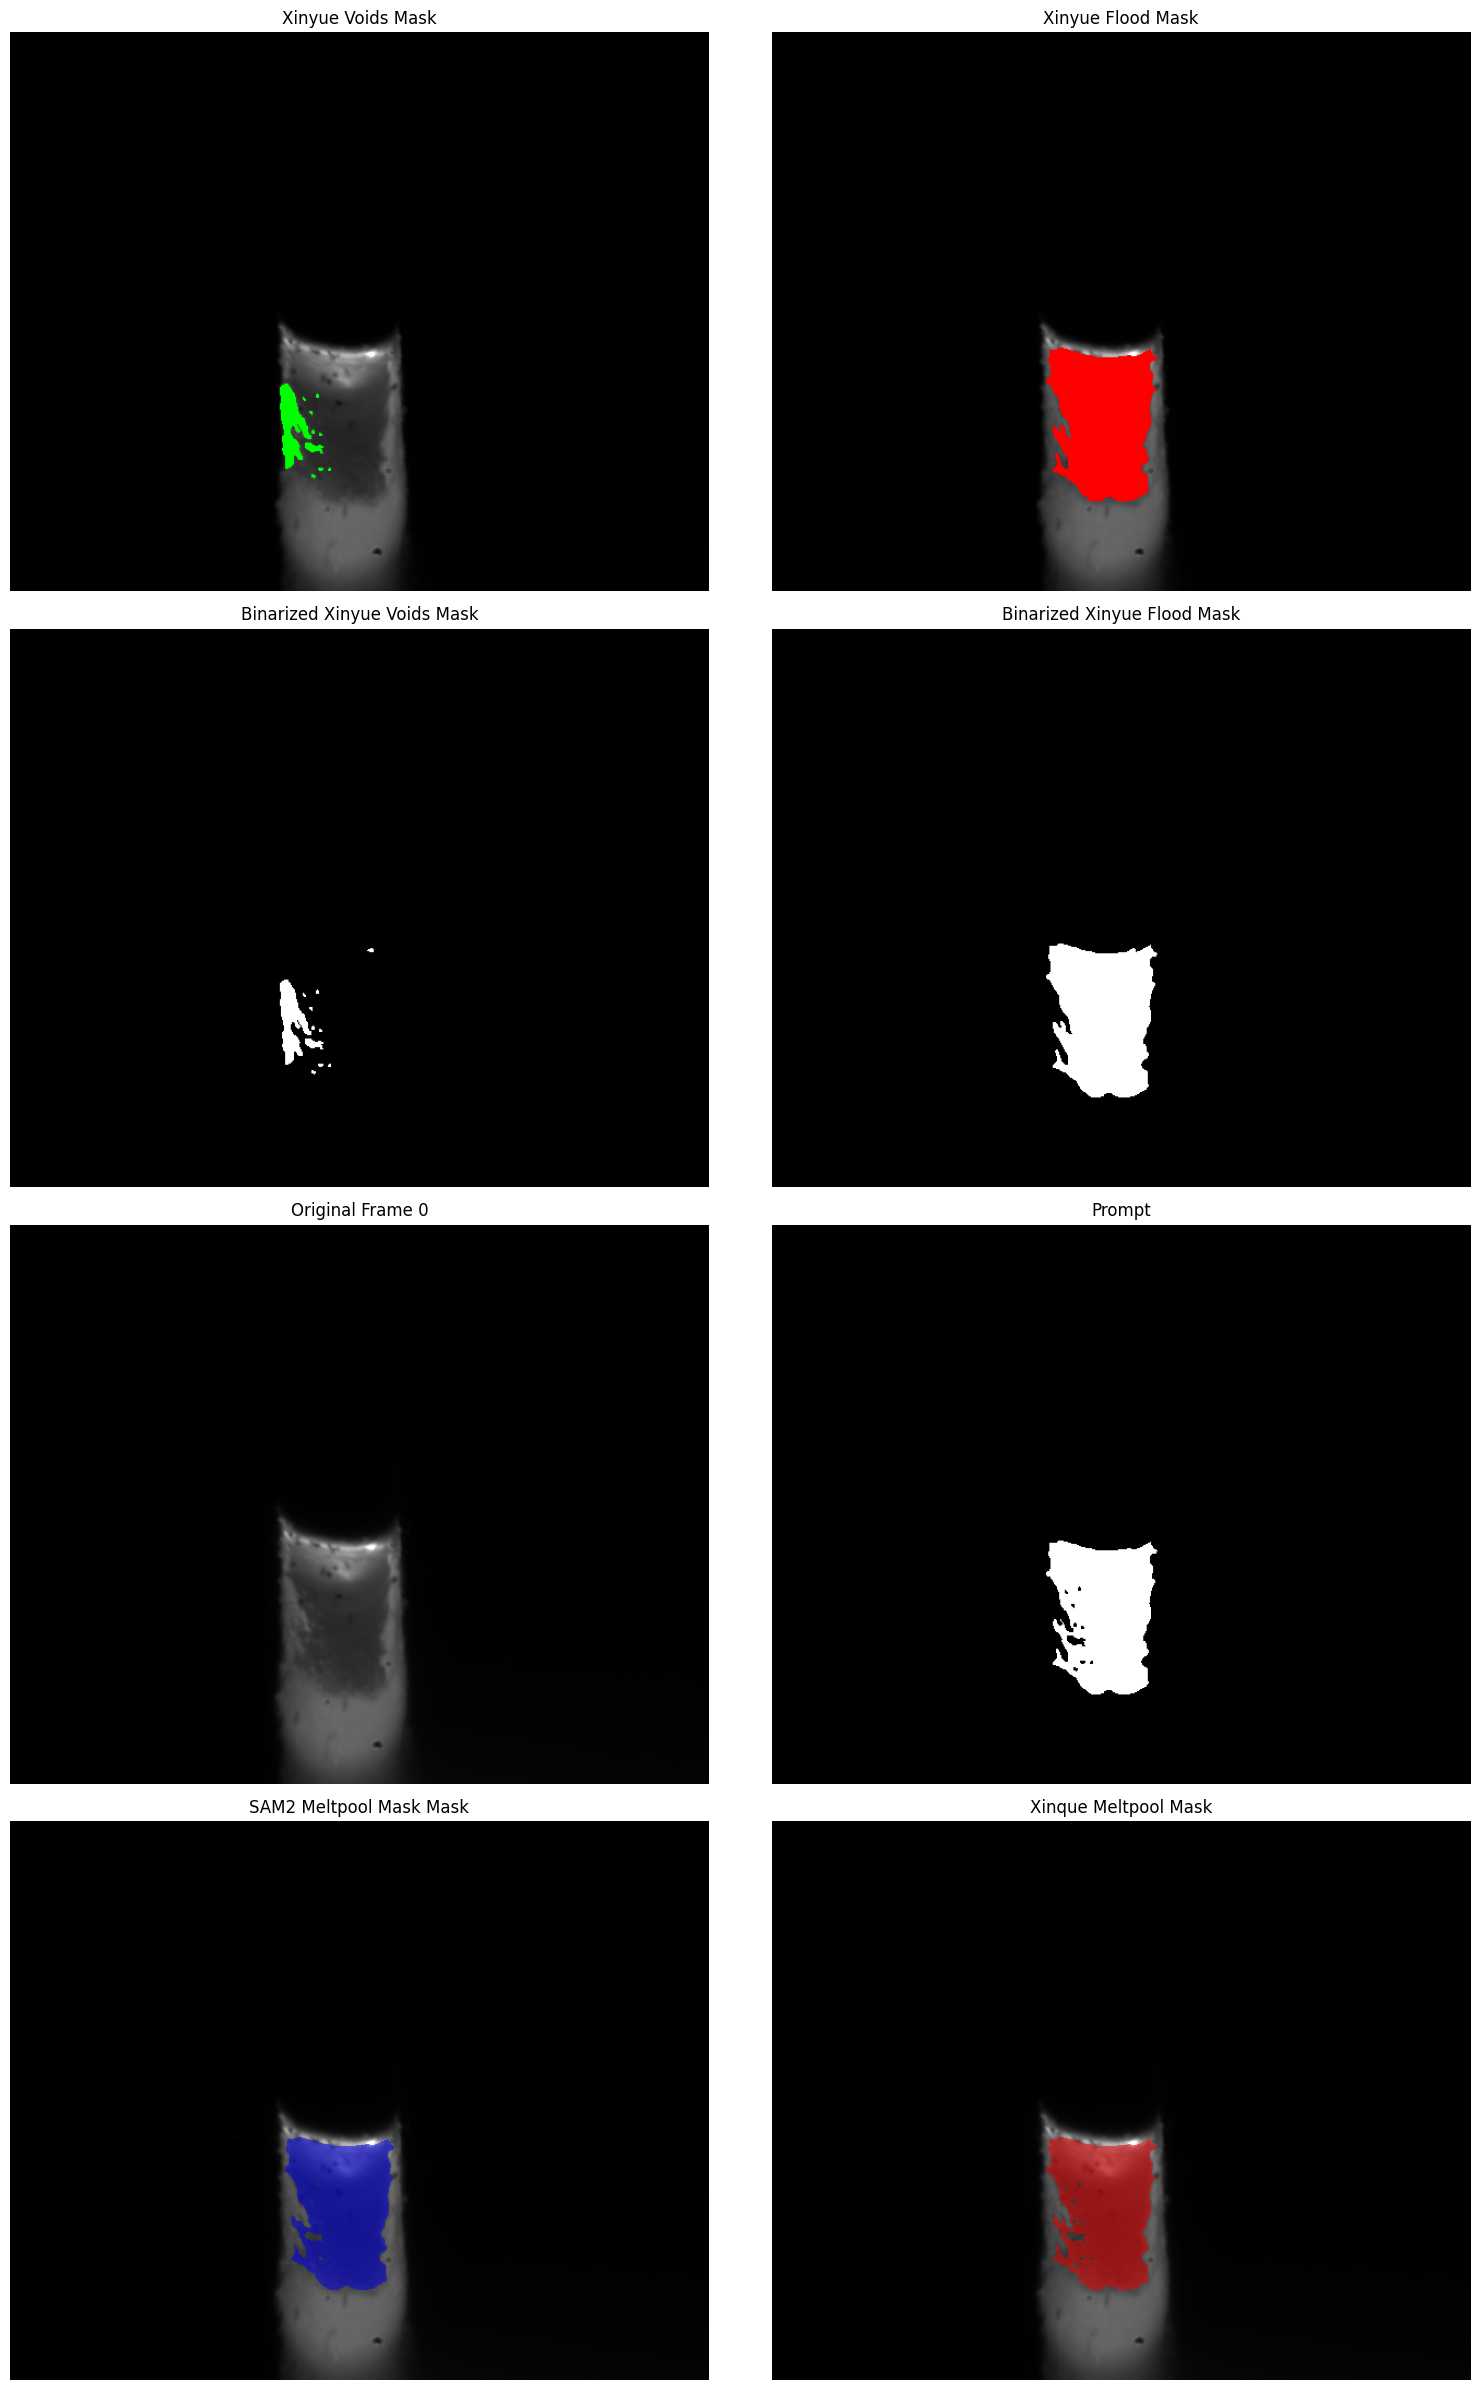

In [14]:
# Load the image and masks
image = Image.fromarray(mask_frame) 
flood_mask = Image.open(os.path.join(masks_directory, flood_mask_path))
voids_mask = Image.open(os.path.join(masks_directory, voids_mask_path))

# Convert masks to binary arrays
flood_mask_binary = np.array(flood_mask)[:, :, 0] > 250  # Extract red channel
void_mask_binary = np.array(voids_mask)[:, :, 1] > 250  # Extract green channel

# Create the meltpool and background masks
meltpool_mask = flood_mask_binary & ~void_mask_binary
background_mask = ~meltpool_mask

# saving the masks
void_mask_binary_img = Image.fromarray(void_mask_binary.astype(np.uint8) * 255)
flood_mask_binary_img = Image.fromarray(flood_mask_binary.astype(np.uint8) * 255)
meltpool_mask_img = Image.fromarray(meltpool_mask.astype(np.uint8) * 255)
background_mask_img = Image.fromarray(background_mask.astype(np.uint8) * 255)

flood_mask_binary_img.save(f"{xinyue_dir}/flood_mask_binary.jpg")
void_mask_binary_img.save(f"{xinyue_dir}/void_mask_binary.jpg")
meltpool_mask_img.save(f"{xinyue_dir}/meltpool_mask.jpg")
background_mask_img.save(f"{xinyue_dir}/background_mask.jpg")
img.save(f"{xinyue_dir}/original.jpg")



ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)
# sample_points_p = sample_points(meltpool_mask, 10)
# sample_points_n = sample_points(background_mask, 10)
# sample_points_n_2 = sample_points(void_mask_binary, 10) 
# points = np.concatenate([sample_points_p, sample_points_n, sample_points_n_2], axis=0)
# labels = np.concatenate([np.ones(len(sample_points_p)), np.zeros(len(sample_points_n)), np.zeros(len(sample_points_n_2))], axis=0)

# for labels, `1` means positive click and `0` means negative click
# _, out_obj_ids, out_mask_logits = predictor.add_new_points(
#     inference_state=inference_state,
#     frame_idx=frame_idx-1,
#     obj_id=ann_obj_id,
#     points=points,
#     labels=labels,
# )
_, out_obj_ids, out_mask_logits = predictor.add_new_mask(
    inference_state=inference_state,
    frame_idx=mask_index, # sam index
    obj_id=ann_obj_id,
    mask=meltpool_mask,
)

# Create a figure with 4x2 subplots
fig, axs = plt.subplots(4, 2, figsize=(16, 24))
# Display images and masks


axs[0, 1].imshow(flood_mask, cmap="gray")
axs[0, 1].set_title("Xinyue Flood Mask")
axs[0, 1].axis('off')

axs[1, 1].imshow(flood_mask_binary, cmap='gray')
axs[1, 1].set_title('Binarized Xinyue Flood Mask')
axs[1, 1].axis('off')

axs[0, 0].imshow(voids_mask, cmap="gray")
axs[0, 0].set_title("Xinyue Voids Mask")
axs[0, 0].axis('off')


axs[1, 0].imshow(void_mask_binary, cmap='gray')
axs[1, 0].set_title('Binarized Xinyue Voids Mask')
axs[1, 0].axis('off')

axs[2, 1].imshow(meltpool_mask, cmap='gray')
axs[2, 1].set_title('Prompt')
axs[2, 1].axis('off')


axs[2, 0].imshow(image, cmap="gray")
axs[2, 0].set_title(f"Original Frame {mask_index}")
axs[2, 0].axis('off')


axs[3, 0].imshow(image)
from matplotlib.colors import ListedColormap
single_color_cmap_blue = ListedColormap(['none', 'blue']) 
SAM2_Mask= (out_mask_logits[0] > 0.0).cpu().numpy().squeeze()
axs[3, 0].imshow(SAM2_Mask, alpha=0.5,cmap=single_color_cmap_blue)  
axs[3, 0].set_title('SAM2 Meltpool Mask Mask')
axs[3, 0].axis('off')

# Overlay meltpool mask on the original image
single_color_cmap_red = ListedColormap(['none', 'red']) 
axs[3, 1].imshow(image, cmap='gray')
axs[3, 1].imshow(meltpool_mask, alpha=0.5,cmap=single_color_cmap_red)  
axs[3, 1].set_title('Xinque Meltpool Mask')
axs[3, 1].axis('off')

plt.tight_layout()
plt.savefig(f"{xinyue_dir}/all_masks.jpg")
plt.show()


#### Step 3: Propagate the prompts to get the masklet across the video

To get the masklet throughout the entire video, we propagate the prompts using the `propagate_in_video` API.

In [15]:
# Assuming out_mask_logits are raw logits, and assuming we are only intrested in single object, we convert them to probabilities for confidence calculation
sigmoid = torch.nn.Sigmoid()
# run propagation throughout the video and collect the results in a dict
video_segments = {}  # video_segments contains the per-frame segmentation results
frame_metrics = {}  # mask_confidence contains the per-frame mask confidence scores
frame_metrics['mask_confidence'] = {}
frame_metrics['frame'] = {}
for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        # out_frame_idx is according sam index
        
        mask = (out_mask_logits[ann_obj_id-1] > 0.0).cpu().numpy() #
        video_segments[out_frame_idx] = mask
        # Convert logits to probabilities for the current mask
        probabilities = sigmoid(out_mask_logits[ann_obj_id-1]).cpu().numpy()
        frame_metrics['mask_confidence'][out_frame_idx] = probabilities[mask].mean()  # Mean confidence of the mask
        frame_metrics['frame'] [out_frame_idx] = frames_indices[out_frame_idx]
        

propagate in video:   0%|          | 0/50 [00:00<?, ?it/s]/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/sam2_video_predictor.py:873: UserWarning: cannot import name '_C' from 'sam2' (/mnt/md126/users/mohamed/projects/segment-anything-2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/segment-anything-2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


In [16]:
# scan all the JPEG frame names in this directory
frame_names = [
    p for p in os.listdir(sam_temp_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]
]
frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

In [17]:


# Assuming `image_meta_data`, `sam_temp_dir`, `frame_names`, `video_segments`, and `sam_results_dir` are defined
vis_frame_stride = 1
vis_dpi = 1200  # Define the DPI you're using for your images
single_color_cmap_blue = ListedColormap(['none', 'blue'])
width = image_meta_data['width']
height = image_meta_data['height']
parameters['vis_frame_stride'] = vis_frame_stride
parameters['vis_dpi'] = vis_dpi
parameters['width'] = width
parameters['height'] = height




# Calculate figure size in inches
fig_width = width / vis_dpi
fig_height = height / vis_dpi
max_digits = len(str(999999999999))
plt.close("all")
for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
    # Create a figure with the computed dimensions
    plt.figure(figsize=(fig_width, fig_height), dpi=vis_dpi)
    plt.imshow(Image.open(os.path.join(sam_temp_dir, frame_names[out_frame_idx])), cmap='gray')
    plt.axis('off')
    plt.tight_layout(pad=0)  # Set padding to zero for tight layout
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove any space between subplots
    # Overlay the segmentation mask
    out_mask = video_segments[out_frame_idx]
    plt.imshow(out_mask.squeeze(), alpha=0.25, cmap=single_color_cmap_blue)
    out_frame_idx_str = str(out_frame_idx).zfill(max_digits)
    plt.savefig(f"{sam_results_dir}/overlay/{out_frame_idx_str}_{frames_indices[out_frame_idx]}.png")

    # Save the mask alone
    plt.figure(figsize=(fig_width, fig_height), dpi=vis_dpi)
    plt.imshow(out_mask.squeeze(), alpha=1, cmap=single_color_cmap_blue)
    
    plt.axis('off')
    plt.tight_layout(pad=0)  # Set padding to zero for tight layout
    plt.subplots_adjust(wspace=0, hspace=0)  # Remove any space between subplots
    plt.savefig(f"{sam_results_dir}/masks/{out_frame_idx_str}_{frames_indices[out_frame_idx]}.png")
    plt.close("all")


In [18]:
# Create a DataFrame to store the mask confidence scores from the dictionary
mask_confidence_df = pd.DataFrame(frame_metrics)
mask_confidence_df['pixel_wise_diff'] = pixel_wise_diff_list

In [19]:
csv_file_dir = f"{temp_dir}/mask_confidence.csv"
parameters['csv_file_dir'] = csv_file_dir
mask_confidence_df.to_csv(csv_file_dir, index=False)

In [20]:
# Save to JSON file
json_file_path = os.path.join(temp_dir, "parameters.json")  # Saving in the same directory as your CSV
with open(json_file_path, 'w') as json_file:
    json.dump(parameters, json_file, indent=4)
print(f"Parameters saved to {json_file_path}")

Parameters saved to ./videos/CREDgt_set_4_20240708_09_00_12072024_113101_v1_selected_mask5_unique_idgt4_v3_ew8r3/parameters.json


In [21]:
import os
from IPython.display import display, clear_output
from ipywidgets import widgets
from PIL import Image
import time

def create_image_animation(folder_path, frame_rate=1):
    """Create an interactive image animation in a Jupyter Notebook.

    Args:
    folder_path (str): Path to the folder containing images.
    frame_rate (float): Number of seconds between frames.
    """
    # List all files in the directory and sort them
    files = sorted([os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))])
    # print(f"Found {len(files)} images in {folder_path}")
    # print(f'Files are {files}')
    # Display widget setup
    output = widgets.Output()
    play_button = widgets.Button(description="Play")
    stop_button = widgets.Button(description="Stop")
    slider = widgets.IntSlider(value=0, min=0, max=len(files) - 1, step=1, description='Frame:')
    play_control = widgets.Play(value=0, min=0, max=len(files) - 1, interval=1000 * frame_rate, show_repeat=False)
    widgets.jslink((play_control, 'value'), (slider, 'value'))  # Link slider and play widget

    # Event handlers for buttons
    def play_animation(b):
        play_control._playing = True

    def stop_animation(b):
        play_control._playing = False

    play_button.on_click(play_animation)
    stop_button.on_click(stop_animation)

    # Function to display the current frame
    def show_current_frame(change):
        frame_index = change['new']
        if output.outputs:  # if there is something already displayed
            output.clear_output(wait=True)
        with output:
            display(Image.open(files[frame_index]))

    slider.observe(show_current_frame, names='value')

    # Arrange buttons and slider
    control_panel = widgets.HBox([play_button, stop_button, slider])
    display(control_panel, play_control, output)

    # Initialize
    show_current_frame({'new': slider.value})

# Example usage
# create_image_animation('/path/to/your/image/directory', frame_rate=0.5)


In [22]:
create_image_animation(f"{sam_results_dir}/overlay/", frame_rate=0.5)

Play(value=0, interval=500, max=49, show_repeat=False)

Output()